# Create Training Set with Simulated Pulsars

Based on Python 3.
Required software:
1. sigpyproc
2. sigproc
3. scipy
4. pandas
5. numpy
6. SKA-TestVectorGenerationPipeline py3
7. Tempo 2

We take a real observation and create an empty, downsampled version of this file. Into this file we inject the simulated pulsars.

This version uses SKA-TestVectorGenerationPipeline v1.0 rewritten as Python 3 at https://github.com/larskuenkel/SKA-TestVectorGenerationPipeline

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from sigpyproc.Readers import FilReader as reader
import scipy.signal
import scipy
import pandas as pd
current_path = os.getcwd()
print(current_path)

/data/lkuenkel/neural_nets/DeepPulsarNet/deeppulsarnet/notebooks


Adjust the paths in the following cell to your system.

In [2]:
# Folder where data will be saved
output_path = '/data/lkuenkel/data/pipeline_test/'
!mkdir -p {output_path}
# Define input file, if not filterbank file yet will be converted later
input_example_file = '/data/lkuenkel/data/PMPS/1997AUGT/raw/PM0001_00111.sf'
# Name for converted filterbank file
input_fil_file = f'{output_path}input.fil'
# Name of downsampled filterbank file
downsampled_input = f'{output_path}example_downsampled.fil'
# Name of empty filterbank file, this file be used to inject the simulated pulsars
empty_file = f'{output_path}zero.fil'

pipeline_path = '/data/lkuenkel/newstack/py3/SKA-TestVectorGenerationPipeline'

mkdir: cannot create directory ‘/data/lkuenkel/data/pipeline_test/’: File exists


## Create Downsampled File
This step creates a downsampled version of one filterbank. If the file is in sigproc filterbank format and you do not want to downsample, then skip this step and set *downsampled_input* to the input file.

In [3]:
# Parameters for downsampling
t_downsample = 10
f_downsample = 2
nbits = 8

tstart = 50000

In the following cell a downsampled version of the example file is created. If the resolution of the example file is already small enough (as is the case with the example PMPS data) you can set 'data_already_downsampled = True'.

In [4]:
# No conversion to filterbank needed if data is already sigproc filterbank
# filterbank and decimate are sigproc tools
data_already_downsampled = False
if data_already_downsampled:
    !filterbank {input_example_file} > {input_fil_file}
    !decimate -c {f_downsample} -t {t_downsample} -n {nbits} {input_fil_file} > {downsampled_input}
else:
    !cp {input_example_file} {downsampled_input}

hdr
Native fch1=1516.500000, foff=-3.000000
hdr
Native fch1=1516.500000, foff=-3.000000


## Create Empty File

In [5]:
fil = reader(downsampled_input)
channel_number = fil.header['nchans']
mask = np.zeros(channel_number)
f_range = (fil.header['fch1'], fil.header['fch1']+fil.header['foff']*fil.header['nchans'])
fil.header['tstart'] = tstart
fil.applyChannelMask(mask, empty_file)


Filterbank reading plan:
------------------------
Called on file:        /data/lkuenkel/data/pipeline_test/example_downsampled.fil
Called by:             applyChannelMask
Number of samps:       840089
Number of reads:       1640
Nsamps per read:       512
Nsamps of final read:  409
Nsamps to skip back:   0

Execution time: 1.317662 seconds     



'/data/lkuenkel/data/pipeline_test/zero.fil'

In [6]:
fil.header

{'source_name': 'G4783503',
 'telescope_id': 4,
 'machine_id': 4294967295,
 'src_raj': 134652.518,
 'src_dej': -613331.02,
 'az_start': 0.0,
 'za_start': 0.0,
 'data_type': 1,
 'fch1': 1516.5,
 'foff': -6.0,
 'nchans': 48,
 'nbits': 8,
 'tstart': 50000,
 'tsamp': 0.0025,
 'nifs': 1,
 'barycentric': 0,
 'hdrlen': 315,
 'filelen': 40324615,
 'nbytes': 40324300,
 'nsamples': 840089,
 'filename': '/data/lkuenkel/data/pipeline_test/example_downsampled.fil',
 'basename': '/data/lkuenkel/data/pipeline_test/example_downsampled',
 'extension': '.fil',
 'bandwidth': 288.0,
 'ftop': 1519.5,
 'fbottom': 1231.5,
 'fcenter': 1375.5,
 'tobs': 2100.2225,
 'ra': '13:46:52.5180',
 'dec': '-61:33:31.0200',
 'ra_rad': 3.6079241221039666,
 'dec_rad': -1.07440054380639,
 'ra_deg': 206.71882499999995,
 'dec_deg': -61.55861666666666,
 'obs_date': '09/10/1995',
 'obs_time': '00:00:00.00000',
 'dtype': '<u1'}

## Create Training Data Set

In [11]:
# Parameters
# number of predictor files
n_files = 20

# These strings contain the parameters for the creation of the simulated files
# Here we use uniform distribution, the first value is the start value, the second value is the range
snr_para = '--snr uniform --snrparams 70:0'
dm_para = '--dm uniform --dmparams 20:680'
p0_para = '--p0 uniform --p0params 0.1:1.4'

set_name = 'training_set_3'

In [12]:
# Create Folders
set_path = f'{output_path}{set_name}'
pars_path = f'{output_path}{set_name}/pars'
preds_path = f'{output_path}{set_name}/pred'
cmd_path = f'{output_path}{set_name}/cmd'
data_path = f'{output_path}{set_name}/data'
fake_prof_path = f'{output_path}{set_name}/prof_fake'

In [13]:
#!mkdir {data_path}

In [25]:
# Reset Folders 
!rm -r {set_path}
!mkdir {set_path}
!mkdir {pars_path}
!mkdir {preds_path}
!mkdir {cmd_path}
!mkdir {data_path}
!mkdir {fake_prof_path}

1. Creates Pars
2. Create Preds
3. Create command list
4. Execute command list

In [26]:
%%capture
command_string = f'-d {pars_path} -w {set_path}/out_pars.txt -s {n_files} {snr_para} {p0_para} {dm_para}'
%run {pipeline_path}/PARS/CandidateParGenerator.py {command_string}

In [29]:
# Unpack profiles
# Some profiles have a low S/N, consider using a subset of very clear profiles

asc_file = f'{pipeline_path}/ASC/ASC.zip'
asc_folder = f'{pipeline_path}/ASC/all_ASC'
!unzip -n -q {asc_file} -d {asc_folder}

In [30]:
chunks = n_files // 1000
f_high = int(np.ceil(max(f_range)))
f_low = int(np.floor(min(f_range)))
command_string = f'--tel PARKES  -p {pars_path} -d {preds_path} -s 2000 --f1 {f_low} --f2 {f_high} --mjd1 {tstart} --mjd2 {tstart+0.2}'
print(command_string)
for chunk in range(chunks+1):
    %run {pipeline_path}/PREDS/GeneratePredictorFiles.py {command_string}

--tel PARKES  -p /data/lkuenkel/data/pipeline_test/training_set_3/pars -d /data/lkuenkel/data/pipeline_test/training_set_3/pred -s 2000 --f1 1228 --f2 1517 --mjd1 50000 --mjd2 50000.2

    **************************************************************************
    |                                                                        |
    |             Generate Tempo 2 predictor Files Version 1.0               |
    |                                                                        |
    **************************************************************************
    | Description:                                                           |
    |                                                                        |
    | Generates TEMPO2 predictor files for all PAR files in a user specified |
    | Directory. The predictor files are stored in a user defined output     |
    | directory. This script is design to run on the par files output by the |
    | CandidateParGenerat

In [32]:
command_string = f'--asc {asc_folder} --pred {preds_path} --out {cmd_path} --noise {empty_file} --batch {n_files} '
print(command_string)
%run {pipeline_path}/INJECT/InjectPulsarCommandCreator.py {command_string} -v

--asc /data/lkuenkel/newstack/py3/SKA-TestVectorGenerationPipeline/ASC/all_ASC --pred /data/lkuenkel/data/pipeline_test/training_set_3/pred --out /data/lkuenkel/data/pipeline_test/training_set_3/cmd --noise /data/lkuenkel/data/pipeline_test/zero.fil --batch 20 

    **************************************************************************
    |                                                                        |
    |              Inject Pulsar Command Creator Version 1.0                 |
    |                                                                        |
    **************************************************************************
    | Description:                                                           |
    |                                                                        |
    | Creates files containing run commands, useful for automating the use   |
    | of inject_pulsar.                                                      |
    |                     

In [33]:
cmd_files = glob.glob(cmd_path+ '/*.txt')
print(cmd_files)

['/data/lkuenkel/data/pipeline_test/training_set_3/cmd/InjectPulsarCommands_1.txt', '/data/lkuenkel/data/pipeline_test/training_set_3/cmd/InjectPulsarCommands_2.txt']


In [34]:
for cmd_file in cmd_files:
    %run {pipeline_path}/INJECT/InjectPulsarAutomator.py --cmd {cmd_file} --out {data_path}


    **************************************************************************
    |                                                                        |
    |                 Inject Pulsar Automator Version 1.0                    |
    |                                                                        |
    **************************************************************************
    | Description:                                                           |
    |                                                                        |
    | Automates the use of inject_pulsar using preprocessed command files.   |
    | These contain the text command to execute using the python subprocess  |
    | library. Each command in the file calls inject_pulsar with three       |
    | parameters: an ascii .asc file describing the a pulse profile, a       |
    | tempo2 predictor file (.dat), and the noise filterbank file to inject  |
    | the signal into.                             

In [37]:
created_files = glob.glob(f'{data_path}/*')

In [39]:
created_files[0]

'/data/lkuenkel/data/pipeline_test/training_set_3/data/FakePulsar_13_0.386233_671.4_70.0_ASC_J1301-6305_1374.fil'

## Create arrays containing the peak position

In [44]:
%%capture
down_fac = 4
out_folder = f'{set_path}/data_dm_{down_fac}/'
!rm -r {out_folder}
!mkdir {out_folder}
correct_files = []
bad_files = []
approx = []
dedis_names = []
max_dedis_vals = []
tsamp = fil.header['tsamp']
for file in created_files[:]:
    #file = '/data/lkuenkel/data/PMPS/fake/pmps_set1/data/FakePulsar_639_1.291910_396.4_70.0_ASC_J2019+2425_1380.fil'
    name = file.split('/')[-1]
    new_name = name.split('.fil')[0]
    name_split = name.split('_')
    full_path = out_folder + new_name +'.npy'
    dm = float(name_split[3])
    period = float(name_split[2])
    approx_dist = 3/4. * period / tsamp /float(down_fac)
    fil = reader(file)
    #fil_data = fil.readBlock(0,10000)
    #plt.imshow(fil_data, aspect='auto')
    #plt.show()
    dedis = fil.dedisperse(dm, gulp=10000000)
    max_val = np.max(dedis)
    down = dedis.downsample(down_fac)
    down -= np.median(down)
    #down = np.clip(down, 0,10000)
    #down = np.clip(down, 0,np.percentile(down, 99))
    down /= np.max(down)
    peaks, prop = scipy.signal.find_peaks(down, height=0.3, distance=approx_dist)
    #plt.plot(dedis)
    #plt.show()
    #peaks = scipy.signal.find_peaks_cwt(down, [5])
    #print(peaks)
    y_val = np.ones_like(peaks[:3]) 
    #plt.plot(down[:2000])
    #plt.scatter(peaks[:3], y_val)
    #plt.show()
    dummy = np.zeros_like(down).astype(bool)
    dummy[peaks] =1
    acf = scipy.signal.fftconvolve(dummy,dummy[::-1])
    acf /= np.max(acf)
    middle = int(len(acf)/2)
    #plt.plot(acf[middle-2000: middle+2000])
    #plt.show()
    try:
        height = np.max(acf[middle+25: middle+5000]) * 0.3
        acf_peaks, _ = scipy.signal.find_peaks(acf[middle-5: middle+5000], height=height)
        #print(acf_peaks)
        per_calc = (acf_peaks[1] -acf_peaks[0])*down_fac * tsamp
        approx.append((period, per_calc))
        if np.abs(period - per_calc)/period>0.15:
            bad_files.append(file)
        else:
            correct_files.append(file)
            dedis_names.append(full_path)
            max_dedis_vals.append(max_val)
    except IndexError:
        print(file + 'did not work')
    np.save(full_path, dummy)
    

20


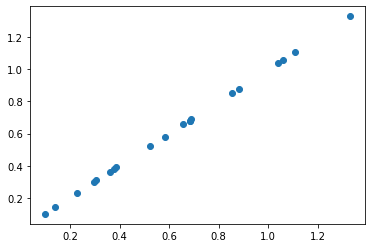

In [45]:
approx_arr = np.asarray(approx)
np.save(f'{set_path}/approx_periods_{down_fac}.npy', approx_arr)
plt.scatter(approx_arr[:,0], approx_arr[:,1])
print(len(correct_files))

## Create csv_file describing the data

We create two csv files. One containing only the simulated files, one another also containing the same amount of empty lines. When these are loaded during the training process, no pulsars are injected. Label 1 tells us that there is a simulated pulsar. Label 0 means no pulsar.

In [46]:
raw_file_paths = correct_files
raw_file_names = [i.split('/')[-1] for i in raw_file_paths]
psr_names = ['',]*len(raw_file_paths)
periods = [float(i.split('_')[2]) for i in raw_file_names]
duty_cycles = [float(i.split('_')[3]) for i in raw_file_names]
dms = [float(i.split('_')[3]) for i in raw_file_names]
snrs = [float(i.split('_')[4]) for i in raw_file_names]
print(len(snrs), len(max_dedis_vals))

20 20


In [47]:
data_dict = {'JNAME':psr_names, 'P0':periods, 'DM':dms, 'Label':np.ones_like(psr_names), 'FileName':raw_file_paths, 
             'SNR': snrs, 'MaskName': dedis_names, 'MaxVal': max_dedis_vals, 'DutyCycle': duty_cycles}
df = pd.DataFrame(data=data_dict)

In [48]:
df[:3]

,JNAME,P0,DM,Label,FileName,SNR,MaskName,MaxVal,DutyCycle
0,,0.386233,671.4,1,/data/lkuenkel/data/pipeline_test/training_set...,70.0,/data/lkuenkel/data/pipeline_test/training_set...,47.0,671.4
1,,1.059307,306.4,1,/data/lkuenkel/data/pipeline_test/training_set...,70.0,/data/lkuenkel/data/pipeline_test/training_set...,142.0,306.4
2,,0.684227,486.8,1,/data/lkuenkel/data/pipeline_test/training_set...,70.0,/data/lkuenkel/data/pipeline_test/training_set...,66.0,486.8


In [49]:
dummy_line = {'JNAME':'Noise', 'P0':np.nan, 'DM':np.nan, 'Label':0, 'FileName':'', 
             'SNR': np.nan, 'MaskName': '', 'MaxVal': np.nan, 'DutyCycle': np.nan}

In [50]:
df_noise = df.copy()
for i in range(len(df)):
    df_noise = df_noise.append(dummy_line, ignore_index=True)

In [51]:
df_noise[-3:]

,JNAME,P0,DM,Label,FileName,SNR,MaskName,MaxVal,DutyCycle
37,Noise,NaN,NaN,0,,NaN,,NaN,NaN
38,Noise,NaN,NaN,0,,NaN,,NaN,NaN
39,Noise,NaN,NaN,0,,NaN,,NaN,NaN


In [52]:
!mkdir ../datasets
df.to_csv(f'../datasets/simset_{set_name}.csv')
df_noise.to_csv(f'../datasets/simset_{set_name}_noise.csv')
print(f"Created: ../datasets/simset_{set_name}.csv")
print(f"Created: ../datasets/simset_{set_name}_noise.csv")
print(f"To use the set use the option: --path simset_{set_name}_noise.csv")

Created: ../datasets/simset_training_set_3.csv
Created: ../datasets/simset_training_set_3_noise.csv
To use the set use the option: --path simset_training_set_3_noise.csv


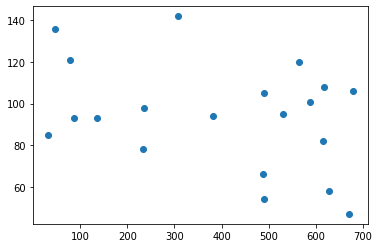

In [53]:
plt.scatter(dms, max_dedis_vals)

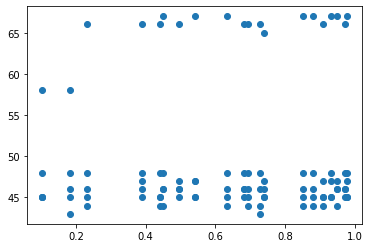

In [107]:
plt.scatter(periods, max_dedis_vals)

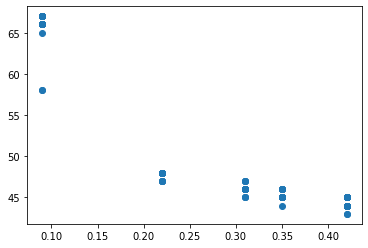

In [108]:
plt.scatter(duty_cycles, max_dedis_vals)